In [2]:
# Implementing a U-net network on Bagls dataset.

import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from natsort import natsorted

from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
import tensorflow as tf
 
import requests

In [3]:
#getting the file directories for x=features and y=masks

data_dir = 'D:/Hamed/Forschungsproject/UNet/training'

x = []
y = []

for filename in natsorted(os.listdir(data_dir)):
    if filename.endswith('.png'):
        if not filename.endswith('_seg.png'):
            x.append(os.path.join(data_dir, filename))
        else:
            y.append(os.path.join(data_dir, filename))



In [4]:
# Load x images
x_images = []
for filename in x:
    img = Image.open(os.path.join(data_dir, filename))
    img = img.resize((256,256))
    img = img.convert('L')
    img_arr = np.array(img,dtype=np.float32)
    img_arr = img_arr / 255
    x_images.append(img_arr)

# Load y images
y_images = []
for filename in y:
    img = Image.open(os.path.join(data_dir, filename))
    img = img.resize((256,256))
    img = img.convert('L')
    img_arr = np.array(img,dtype=np.float32)
    img_arr[img_arr > 1] = 1
    img_arr[img_arr < 1] = 0
    y_images.append(img_arr)
    


In [5]:
np.shape(x_images[0]),np.shape(y_images[0])



((256, 256), (256, 256))

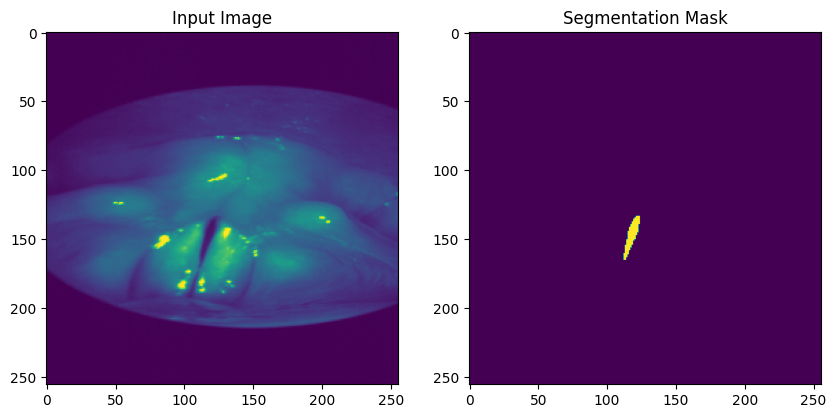

(256, 256)

In [6]:
#example plot of x,y

i=np.random.randint(0,len(y_images))

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(x_images[i])
axs[0].set_title('Input Image')
axs[1].imshow(y_images[i])
axs[1].set_title('Segmentation Mask')
plt.show()
np.shape(x_images[2])

In [7]:
#spliting the data

testno = int(len(x) * (80/100)) 
valno = int(testno + len(x) * (10/100))
trainno = int(valno + len(x) * (10/100))

x_train, y_train = np.array(x_images[:testno],dtype=np.float32), np.array(y_images[:testno],dtype=np.float32)
x_val, y_val = np.array(x_images[testno:valno],dtype=np.float32), np.array(y_images[testno:valno],dtype=np.float32)
x_test, y_test = np.array(x_images[valno:trainno],dtype=np.float32), np.array(y_images[valno:trainno],dtype=np.float32)

# Print number of samples in each set
print('Number of samples in training set:', len(x_train))
print('Number of samples in validation set:', len(x_val))
print('Number of samples in test set:', len(x_test))

Number of samples in training set: 44600
Number of samples in validation set: 5575
Number of samples in test set: 5575


In [16]:

inputs = Input((256, 256,1))


# Contractive
conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
drop1 = Dropout(0.1)(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(drop1)

conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
drop2 = Dropout(0.1)(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(drop2)

conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
drop3 = Dropout(0.2)(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(drop3)

conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
drop4 = Dropout(0.2)(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
drop5 = Dropout(0.3)(conv5)

# Expansive 
up6 = Conv2DTranspose(512, 2, padding = 'same',strides=(2,2))(drop5)
merge6 = concatenate([drop4,up6], axis = 3)
conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

up7 = Conv2DTranspose(256, 2, padding = 'same',strides=(2,2))(conv6)
merge7 = concatenate([conv3,up7], axis = 3)
conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
drop7 = Dropout(0.2)(conv7)

up8 = Conv2DTranspose(128, 2, padding = 'same',strides=(2,2))(drop7)
merge8 = concatenate([conv2,up8], axis = 3)
conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
drop8 = Dropout(0.1)(conv8)

up9 = Conv2DTranspose(64, 2, padding = 'same',strides=(2,2))(drop8)
merge9 = concatenate([conv1,up9], axis = 3)
conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)

drop9 = Dropout(0.1)(conv9)

conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(drop9)
conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

model = Model(inputs = inputs, outputs = conv10)


#model.summary()




In [8]:
class BotCallback(tf.keras.callbacks.Callback):
    logs_arr = []
    def __init__(self, personal_token=None):
        self.personal_token = '5964545787:AAEQH7xnHonOarFiILcsftnbryRmOqWyCFk'
        self.ping_url = 'https://api.telegram.org/bot'+str(self.personal_token)+'/getUpdates'
        self.response = requests.get(self.ping_url).json()
        self.chat_id = self.response['result']

    def send_message(self,message):
        self.ping_url = 'https://api.telegram.org/bot'+str(self.personal_token)+'/sendMessage?'+\
                        'chat_id='+str(self.chat_id)+\
                        '&parse_mode=Markdown'+\
                        '&text='+message
        self.response = requests.get(self.ping_url)

    def on_epoch_end(self, epoch, logs):
        ac = logs['accuracy']
        loss = logs['loss']
        text = f"*Epoch*: {str(epoch)}\nAccuracy: {str(ac)}\nloss: {str(loss)}."
        self.send_message(f'{epoch}, {logs}') 
        if epoch == 9:
            self.send_message("*THE END*") 
            
from keras.callbacks import EarlyStopping

earlystop_callback = EarlyStopping(
    monitor='val_loss', 
    min_delta=0.001,
    patience=3,
    verbose=1, 
    mode='auto' 
)

In [17]:
from segmentation_models.losses import DiceLoss
from segmentation_models.metrics import iou_score

loss = DiceLoss()
metric = iou_score
#del model

In [19]:
model.compile(optimizer = 'Adam', loss=loss, metrics=[iou_score])
history = model.fit(x_train[0:3000], y_train[0:3000],validation_data=[x_val, y_val], epochs=5, batch_size=1,shuffle=True) #30,000 cause the momery runs out

Epoch 1/5
3000/3000 [==============================] - 172s 57ms/step - loss: 0.9871 - iou_score: 0.0068 - val_loss: 0.9875 - val_iou_score: 0.0064
Epoch 2/5
3000/3000 [==============================] - 170s 57ms/step - loss: 0.9871 - iou_score: 0.0068 - val_loss: 0.9875 - val_iou_score: 0.0064
Epoch 3/5
3000/3000 [==============================] - 169s 56ms/step - loss: 0.9870 - iou_score: 0.0068 - val_loss: 0.9874 - val_iou_score: 0.0065
Epoch 4/5
3000/3000 [==============================] - 172s 57ms/step - loss: 0.9870 - iou_score: 0.0068 - val_loss: 0.9874 - val_iou_score: 0.0065
Epoch 5/5
3000/3000 [==============================] - 177s 59ms/step - loss: 0.9869 - iou_score: 0.0069 - val_loss: 0.9874 - val_iou_score: 0.0065


In [21]:
history.history

{'loss': [0.9870679378509521,
  0.9870675206184387,
  0.9870061874389648,
  0.9869583249092102,
  0.9869387745857239],
 'iou_score': [0.006789337377995253,
  0.006789337377995253,
  0.006817558780312538,
  0.006846331991255283,
  0.006856703665107489],
 'val_loss': [0.9875217080116272,
  0.9875217080116272,
  0.9874352812767029,
  0.9874069094657898,
  0.9873972535133362],
 'val_iou_score': [0.006437936332076788,
  0.006437936332076788,
  0.0064827813766896725,
  0.00649680383503437,
  0.006502574775367975]}

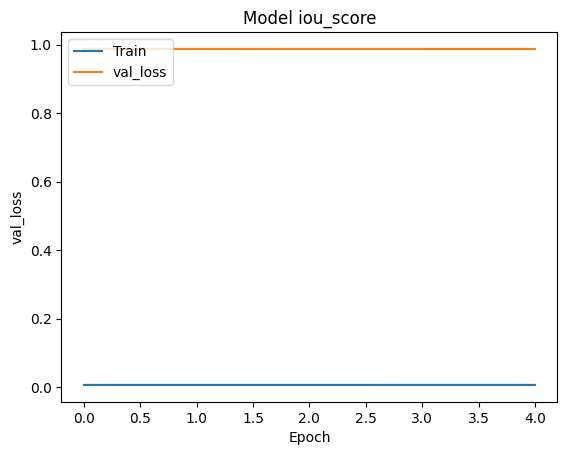

In [22]:
#how was the network on each epoch?

plt.plot(history.history['iou_score'])
plt.plot(history.history['val_loss'])
plt.title('Model iou_score')
plt.ylabel('val_loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'val_loss'], loc='upper left')
plt.show()

In [23]:
y_pred = model.predict(x_test)

score = model.evaluate(x_test, y_test)
np.shape(y_pred)

175/175 [==============================] - 22s 126ms/step - loss: 0.9860 - iou_score: 0.0071


(5575, 256, 256, 1)

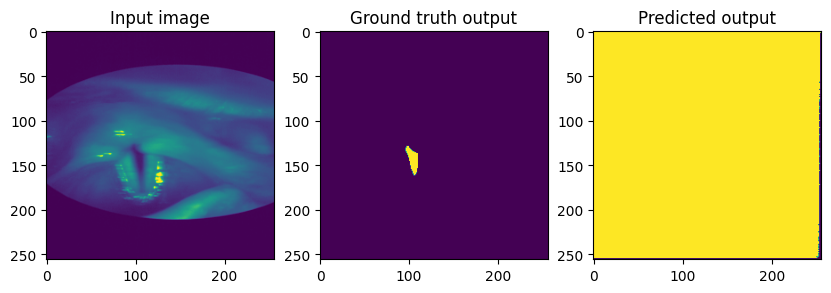

In [27]:
# Choose an index i to plot
i = random_num = np.random.randint(0,300)

# Create a figure with three subplots arranged horizontally
fig, axs = plt.subplots(1, 3, figsize=(10, 5))

# Plot the input image in the first subplot
axs[0].imshow(x_test[i, :, :])
axs[0].set_title('Input image')

# Plot the ground truth output in the second subplot
axs[1].imshow(y_test[i, :, :])
axs[1].set_title('Ground truth output')

# Plot the predicted output in the third subplot
axs[2].imshow(y_pred[i, :, :])
axs[2].set_title('Predicted output')

# Show the figure
plt.show()